In [2]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
from collections import Counter

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
# from cutmix import CutMixCollator, CutMixCriterion
from sklearn import svm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [11]:
set_random_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
def get_loader(root,patch_size: str):#use_cutmix = True, alpha = 1.0,):
    """prepares dataset loaders according to a flag
      #patch_size:
          choose from [2,4,8,16,32,64,128,256]#
      Param:
      ---------
      flag_entire_dataset (bool):
          loads entire dataset if True otherwise loads 1000 images per class
      
      use_cutmix (bool):
          flag to control the usage of cut mix data augmentation
      
      alpha (float):
          parameter for using cutmix data augmentation
      
      return:
      ---------
          train/validate/test loaders for the entire dataset or a subset of it       
        """
     
    data_dir = root
    
    data_transforms = {'train': transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                          transforms.Resize((224,224)),
                                          transforms.RandomResizedCrop(224,scale=(0.7, 1.0)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ColorJitter(brightness=[0.95,1.05],contrast = [0.95,1.05],hue=(-0.05,0.05))#
                                         ]), 
                       'test': transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                          transforms.Resize((224,224)),
                                         ])}
        
    augment_trainable_dataset = datasets.ImageFolder(data_dir+ patch_size + "cm", data_transforms['test'])
    #test_set = datasets.ImageFolder(os.path.join(data_dir, "testing"),data_transforms['test'])
    
    class_names = augment_trainable_dataset.classes
    print('\nClasses names: ',class_names,'\n')
    test_split = 0.2 # 20% split for testing
    dataset_size = len(augment_trainable_dataset)
    print('dataset length: ', dataset_size)
    
    per_class_count = dict(Counter(augment_trainable_dataset.targets))
    print(f"\nSize of test dataset per class:\Twigs: {per_class_count[0]} images\Grass: {per_class_count[1]} images" )
    
    size_class_1 = 98
    test_size_1 = int(round(size_class_1 * test_split,0))
    train_size_1 = int(round(size_class_1 - test_size_1,0))
    indices_class_1 = torch.randperm(size_class_1)
    test_indices_class_1 = indices_class_1[:test_size_1]
    train_indices_class_1 = indices_class_1[test_size_1:]
    #assert(train_size_1 == train_indices_class_1.shape.item())
    
    size_class_2 = 44
    size_class_2_increment = size_class_1
    test_size_2 = int(round(size_class_2 * test_split,0))
    train_size_2 = int(round(size_class_2 - test_size_2,0))
    
    indices_class_2 = torch.randperm(size_class_2)+size_class_2_increment
    test_indices_class_2 = indices_class_2[:test_size_2]
    train_indices_class_2 = indices_class_2[test_size_2:]
    
    
    size_class_3 = 79
    size_class_4 = 91
    size_class_5 = 133
    
    train_indices = torch.cat((train_indices_class_1,train_indices_class_2))
    test_indices = torch.cat((test_indices_class_1,test_indices_class_2))
    
    train_set = torch.utils.data.Subset(augment_trainable_dataset, train_indices)    
    test_set = torch.utils.data.Subset(augment_trainable_dataset, test_indices)       
    
    
    # split training set to training (80%) and validation (20%)
#     train_split = int(round(0.8 * len(augment_trainable_dataset),0))
#     valid_split = int(round(len(augment_trainable_dataset) - train_split,0))
#     train_set, valid_set = torch.utils.data.random_split(augment_trainable_dataset, [train_split, valid_split], generator=torch.Generator().manual_seed(17))

    N_train = len(train_set)
#     N_valid = len(valid_set)
    N_test = len(test_set)
    print(f"Total trainable dataset size: {len(augment_trainable_dataset)} images")
    print(f"Training set size: {N_train} images")
    print(f"Test set size: {N_test} images")


    # cutmix data augmentation
#     if use_cutmix:
#         collator = CutMixCollator(alpha)
#     else:
    collator = torch.utils.data.dataloader.default_collate
        
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collator, num_workers=4)
    #valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True, collate_fn=collator, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)
    
    return train_loader,test_loader, class_names

root = 'data/sorted-data/field-c-points-'
patch_size = '256'

train_loader,test_loader, class_names = get_loader(root,patch_size)



Classes names:  ['1- Twig Clusters', '2- Grass patches', '3- Shrubs', '4- Standing -Trees', '5- Misc'] 

dataset length:  445

Size of test dataset per class:\Twigs: 98 images\Grass: 44 images
Total trainable dataset size: 445 images
Training set size: 113 images
Test set size: 29 images
['1- Twig Clusters', '2- Grass patches', '3- Shrubs', '4- Standing -Trees', '5- Misc']
--Call--
> /home/omar/anaconda3/lib/python3.8/site-packages/IPython/core/displayhook.py(252)__call__()
    250         sys.stdout.flush()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.
    254 



ipdb>  class_names


*** NameError: name 'class_names' is not defined


ipdb>  exit


BdbQuit: 

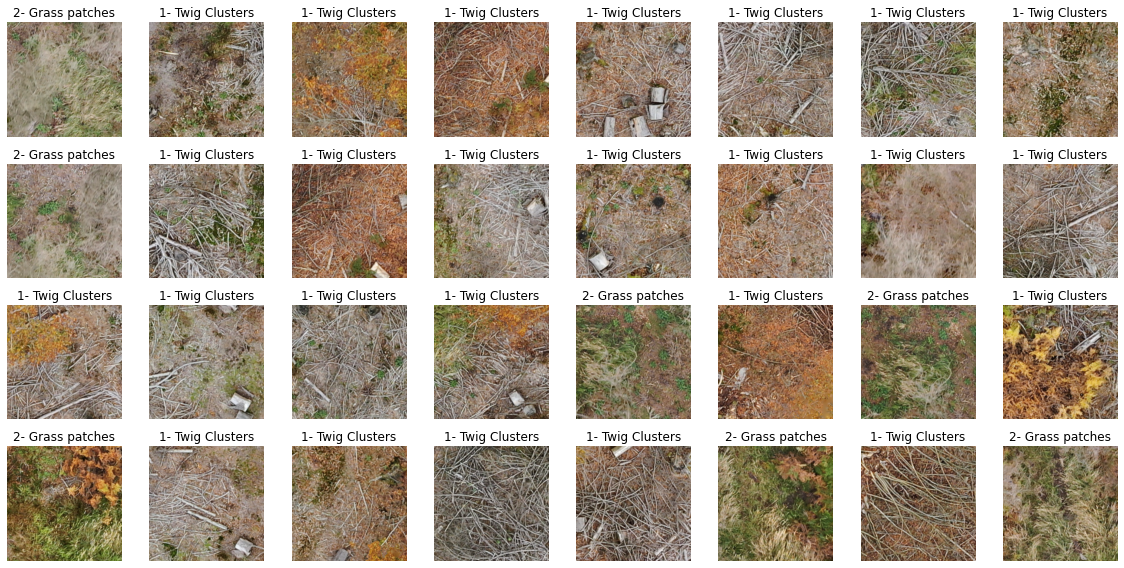

In [31]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

In [3]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/omar/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
